In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
#from tqdm import tqdm
#tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')
import gc
from nltk.tokenize import TweetTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/quora-insincere-questions-classification/test.csv
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec
/kaggle/input/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/paragram_300_sl999.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/README.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin


In [2]:
train_df=pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df=pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
test_df['target']=None
df = pd.concat([train_df, test_df],axis=0, join='outer')
test_df.drop('target',axis=1, inplace=True)
print(f'Train shape:{train_df.shape}\nTest shape:{test_df.shape}\nTotal df shape:{df.shape}\n')

Train shape:(1306122, 3)
Test shape:(375806, 2)
Total df shape:(1681928, 3)



In [3]:
df['new_question_text'] = df['question_text'].map(lambda x: x.lower() if isinstance(x,str) else x)

In [4]:
cloud_stop = set(STOPWORDS)
cloud = WordCloud(background_color='white', stopwords=cloud_stop).generate(df['new_question_text'].str.cat(sep=', '))

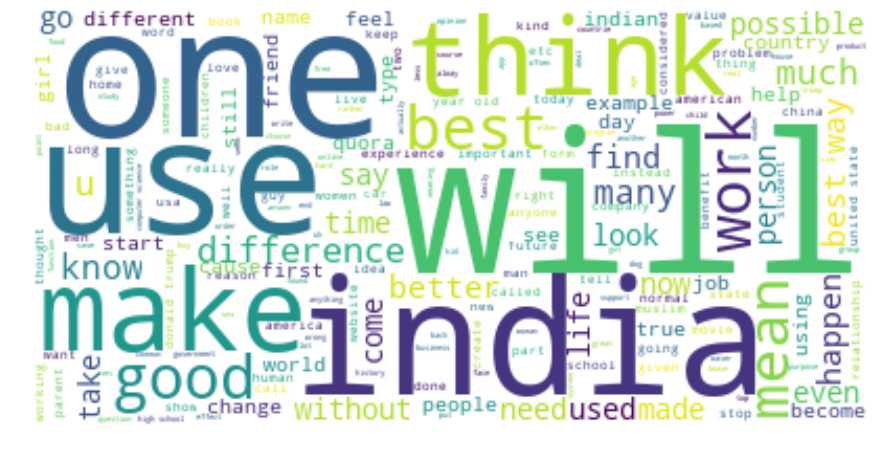

In [5]:
plt.figure(figsize=(15,20))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

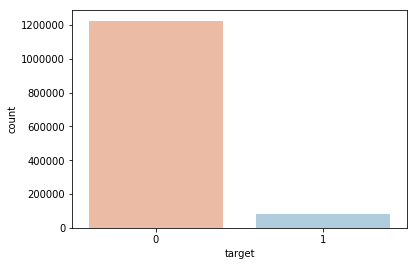

In [6]:
sns.countplot(x='target', data=train_df, palette='RdBu')

In [7]:
tokenizer = TweetTokenizer().tokenize
vect = TfidfVectorizer(tokenizer=tokenizer, ngram_range=(1,3),max_df=0.3)
vect.fit(df['question_text'].values)
vect_train = vect.transform(train_df['question_text'])
vect_test = vect.transform(test_df['question_text'])
vect_y = train_df['target']

In [8]:
logreg = LogisticRegression(class_weight='balanced',n_jobs=-1,C=10)
scores= cross_val_score(logreg, vect_train, vect_y, scoring='f1_macro',n_jobs=-1, cv=3)
print(f'Cross_Val\nScore:{np.mean(scores)} +/- {np.std(scores)}')

Cross_Val
Score:0.8075657858514033 +/- 0.0002557446985227343


In [9]:
logreg.fit(vect_train, vect_y)
pred = logreg.predict_proba(vect_test)
#print(pred)

In [10]:
test_df['prediction'] = np.argmax(pred,axis=1)
test_df.drop('question_text',axis=1, inplace=True)
test_df.to_csv('submission.csv',index=False)